<a href="https://colab.research.google.com/github/MovinduSenura/Chest-Xray-Pneumonia-Detection/blob/dev-senura/notebooks/CustomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTS

import os
import sys
import importlib
from datetime import datetime
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from PIL import ImageFile

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from google.colab import drive

In [2]:
# FIX TRUNCATED/CORRUPTED IMAGES

ImageFile.LOAD_TRUNCATED_IMAGES = True

# CLONE GITHUB REPOSITORY

if not os.path.exists('Chest-Xray-Pneumonia-Detection'):
    !git clone https://github.com/MovinduSenura/Chest-Xray-Pneumonia-Detection.git

# ADD NOTEBOOKS FOLDER TO PYTHON PATH

sys.path.append('/content/Chest-Xray-Pneumonia-Detection/notebooks/')

# IMPORT PREPROCESSING MODULE

import preprocessing
importlib.reload(preprocessing)
from preprocessing import create_generators, prepare_validation_split

# MOUNT GOOGLE DRIVE

drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/DL_Assignment/chest_xray/'

Cloning into 'Chest-Xray-Pneumonia-Detection'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 236 (delta 89), reused 5 (delta 5), pack-reused 69 (from 2)
Receiving objects: 100% (236/236), 372.40 KiB | 7.60 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Mounted at /content/drive


In [3]:
# PREPARE VALIDATION SPLIT & CREATE GENERATORS

prepare_validation_split(DATA_DIR)
train_gen, val_gen, test_gen = create_generators(DATA_DIR)
print("✅ Data generators created successfully!\n")

# COMPUTE CLASS WEIGHTS

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

✅ Validation folder created at /content/drive/MyDrive/DL_Assignment/chest_xray/val_fixed
Found 5216 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
✅ Data generators created successfully!

Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [4]:
# BUILD CUSTOM CNN MODEL

model = Sequential([
    # Conv Block 1
    Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005), input_shape=(128,128,3)),
    BatchNormalization(),
    Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Conv Block 2
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Conv Block 3
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully Connected
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'])
model.summary()

# DEFINE CALLBACKS

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/DL_Assignment/Results5/best_model_cpu.keras',
                    monitor='val_accuracy', save_best_only=True, verbose=1)
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 89,617 (350.07 KB)

 Trainable params: 89,169 (348.32 KB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
# TRAIN MODEL

print("\n🚀 Starting optimized CPU training...\n")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


🚀 Starting optimized CPU training...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9167 - Recall: 0.6998 - accuracy: 0.7317 - loss: 0.6577
Epoch 1: val_accuracy improved from -inf to 0.74297, saving model to /content/drive/MyDrive/DL_Assignment/Results5/best_model_cpu.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - Precision: 0.9168 - Recall: 0.7000 - accuracy: 0.7319 - loss: 0.6575 - val_Precision: 0.7430 - val_Recall: 1.0000 - val_accuracy: 0.7430 - val_loss: 2.2092 - learning_rate: 5.0000e-04
Epoch 2/25
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9646 - Recall: 0.8134 - accuracy: 0.8394 - loss: 0.4824
Epoch 2: val_accuracy did not improve from 0.74297
326/326 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - Precision: 0.9646 - Recall: 0.8134 - accuracy: 0.8394 - loss: 0.4824 - val_Precision: 1.0000 - val_Recall: 0.0361 - val_accuracy: 0.2839 - val_loss: 2.1005 - learning_rate: 5.0000e-04
Epoch 3/25
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9682 - Recall: 0.8375 - accuracy: 0.8589 - loss

39/39 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - Precision: 0.4590 - Recall: 0.6063 - accuracy: 0.8404 - loss: 0.5230

✅ Test Accuracy: 0.8750
✅ Precision: 0.8732, Recall: 0.9359, F1: 0.9035
✅ Test Loss: 0.4119


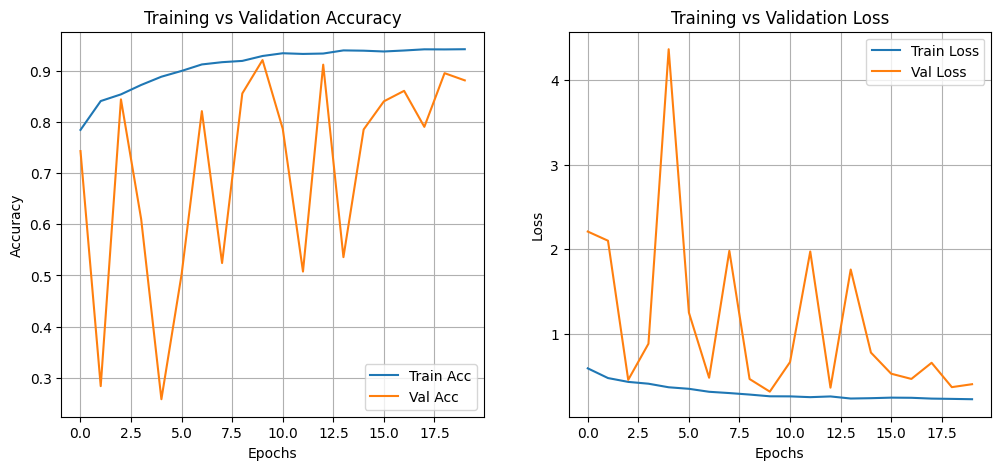

39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 534ms/step


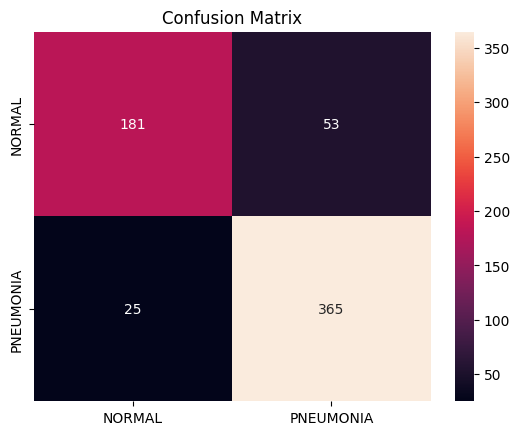

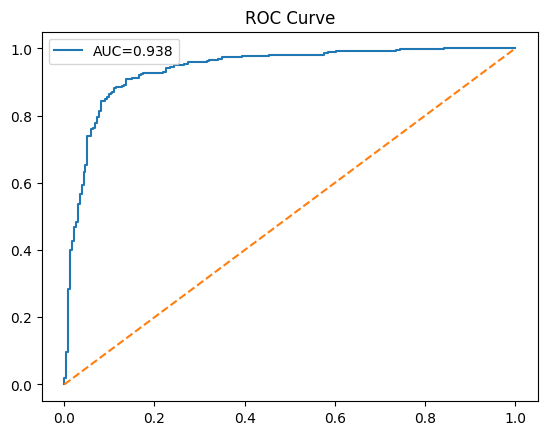

ROC AUC Score: 0.9380
✅ Model saved successfully!
✅ Metrics logged to /content/drive/MyDrive/DL_Assignment/Results5/training_logs.csv


In [6]:
# EVALUATE ON TEST SET

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_gen)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# PLOT ACCURACY & LOSS GRAPHS

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()

# CONFUSION MATRIX & ROC CURVE

y_pred = model.predict(test_gen)
y_pred_classes = np.where(y_pred>0.5,1,0).flatten()
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix'); plt.show()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'--'); plt.title('ROC Curve'); plt.legend(); plt.show()
print(f"ROC AUC Score: {roc_auc:.4f}")

# SAVE MODEL & LOG RESULTS

model.save('/content/drive/MyDrive/DL_Assignment/Results5/CustomCNN_Optimized.keras')
print("✅ Model saved successfully!")

log_file = '/content/drive/MyDrive/DL_Assignment/Results5/training_logs.csv'
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

row = [
    timestamp,
    history.history['accuracy'][-1],
    history.history['val_accuracy'][-1],
    history.history['loss'][-1],
    history.history['val_loss'][-1],
    history.history['Precision'][-1],
    history.history['val_Precision'][-1],
    history.history['Recall'][-1],
    history.history['val_Recall'][-1],
    max(history.history['val_accuracy']),
    min(history.history['val_loss']),
    test_acc, test_loss, test_precision, test_recall, test_f1, roc_auc,
    len(history.history['accuracy']),
    history.history['accuracy'][-1]-history.history['val_accuracy'][-1],
    model.count_params()
]

if not os.path.exists(log_file):
    with open(log_file,'w',newline='') as f:
        writer = csv.writer(f)
        header = ['Timestamp','Train_Acc','Val_Acc','Train_Loss','Val_Loss',
                  'Train_Precision','Val_Precision','Train_Recall','Val_Recall',
                  'Best_Val_Acc','Best_Val_Loss',
                  'Test_Acc','Test_Loss','Test_Precision','Test_Recall','Test_F1','Test_ROC_AUC',
                  'Epochs_Trained','Overfitting_Gap','Total_Params']
        writer.writerow(header)
        writer.writerow(row)
else:
    with open(log_file,'a',newline='') as f:
        writer = csv.writer(f)
        writer.writerow(row)

print(f"✅ Metrics logged to {log_file}")
